In [49]:
import cv2
import time
import utils
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [64]:
zoom = 17
tile_size = 256

### Load downlaoded OSM solar plant shapes
- store it into GPD
- filter out shapes that are not Polygons
- for each shape we get requred tiles to get the satelate img
- for eaxh shape we get the pixel offset of tile start
- for each shape we get its polygon pixel points relative to image start

In [65]:
def get_poly_pixels(row):
    lon_coords, lat_coords = np.asarray(row.geometry.exterior.coords.xy)
    pixel_x, pixel_y = utils.lat_lon_to_pixel_vec(lat_coords, lon_coords, zoom, tile_size)
    
    pixel_x = pixel_x - row.px_offst_x
    pixel_y = pixel_y - row.px_offst_y
    poly_coords = np.c_[pixel_x, pixel_y]
    poly_coords = poly_coords.reshape((-1,1,2))
    return poly_coords

In [66]:
%%time
data = utils.load_json_file('raw_osm_extract_01-10-2022.json')

gdf = gpd.GeoDataFrame.from_features(data, crs='epsg:4326', columns=['geometry'])
gdf = gdf[gdf.geometry.type == 'Polygon']

gdf['tiles_x'], gdf['tiles_y'] = zip(*gdf.geometry.bounds.apply(lambda x: utils.bounds_to_tiles(*x, zoom), axis=1))

gdf['px_offst_x'] = gdf.tiles_x.map(lambda x: min(x)*256)
gdf['px_offst_y'] = gdf.tiles_y.map(lambda x: min(x)*256)

gdf['poly_px_coords'] = gdf.apply(get_poly_pixels, axis=1)

gdf

CPU times: total: 11.9 s
Wall time: 12.4 s


,geometry,tiles_x,tiles_y,px_offst_x,px_offst_y,poly_px_coords
0,"POLYGON ((-116.82924 34.86980, -116.82148 34.8...","[22999, 23000, 23001, 23002]","[51975, 51976, 51977]",5887744,13305600,"[[[197, 40]], [[920, 42]], [[922, 518]], [[197..."
1,"POLYGON ((12.74887 48.80562, 12.75227 48.80560...","[70177, 70178, 70179, 70180, 70181]","[45117, 45118, 45119, 45120]",17965312,11549952,"[[[184, 944]], [[501, 947]], [[505, 951]], [[5..."
2,"POLYGON ((8.65386 41.91298, 8.65454 41.91295, ...","[68686, 68687]",[48698],17583616,12466688,"[[[198, 195]], [[261, 199]], [[261, 192]], [[1..."
3,"POLYGON ((5.92809 45.57926, 5.92811 45.57923, ...",[67694],"[46849, 46850]",17329664,11993344,"[[[90, 280]], [[92, 284]], [[94, 287]], [[97, ..."
4,"POLYGON ((3.97887 43.65232, 3.97886 43.65239, ...",[66984],[47835],17147904,12245760,"[[[169, 211]], [[168, 202]], [[70, 217]], [[71..."
...,...,...,...,...,...,...
26699,"POLYGON ((140.73642 38.11872, 140.73690 38.118...","[116775, 116776]",[50503],29894400,12928768,"[[[400, 84]], [[445, 128]], [[405, 202]], [[38..."
26700,"POLYGON ((140.73795 38.11655, 140.73795 38.115...","[116776, 116777]",[50504],29894656,12929024,"[[[287, 85]], [[288, 169]], [[271, 177]], [[25..."
26701,"POLYGON ((85.81354 47.49804, 85.80962 47.49795...","[96778, 96779, 96780, 96781, 96782, 96783, 96784]","[45834, 45835, 45836, 45837, 45838, 45839, 45840]",24775168,11733504,"[[[450, 83]], [[83, 96]], [[450, 650]], [[585,..."
26702,"POLYGON ((5.68849 53.01136, 5.69002 53.01214, ...","[67606, 67607]","[42688, 42689, 42690]",17307136,10928128,"[[[285, 530]], [[428, 410]], [[410, 384]], [[4..."


### Downloading Images, creatin masks and saving as dataset

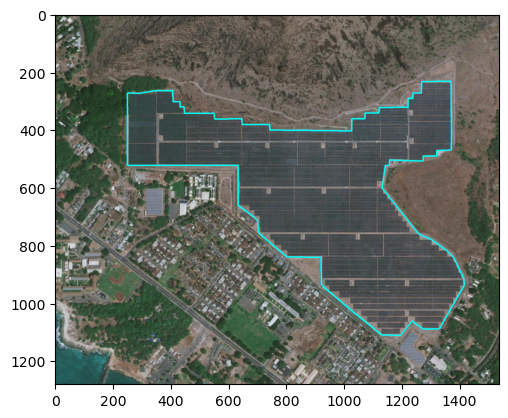

In [67]:
for row_index, row_data in gdf.loc[[11704]].iterrows():
    img = utils.download_img_from_tiles(row_data.tiles_x, row_data.tiles_y, zoom)
    
    outlined_img = cv2.polylines(img, [row_data.poly_px_coords], True, (0,255,255), thickness=3)
    plt.imshow(outlined_img)
    plt.show()
    

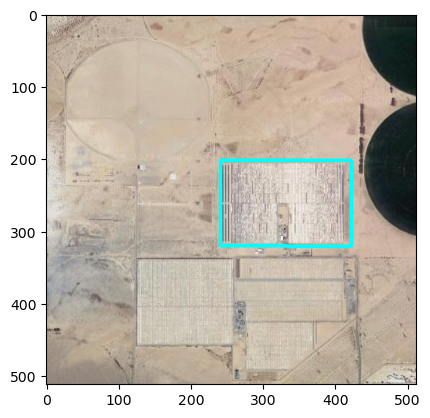

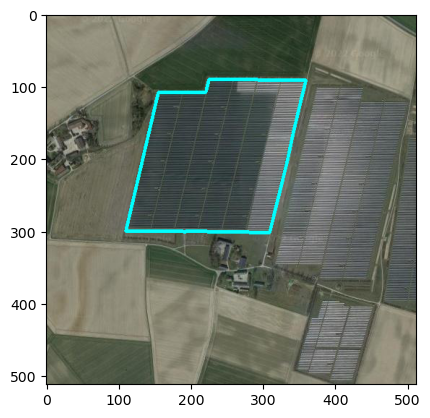

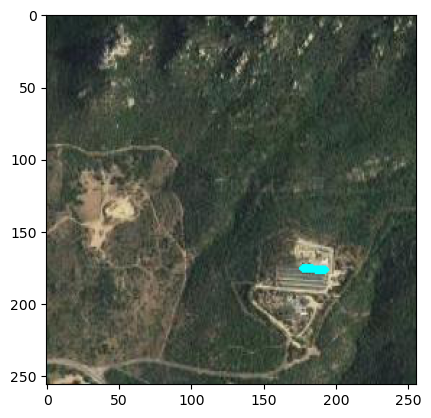

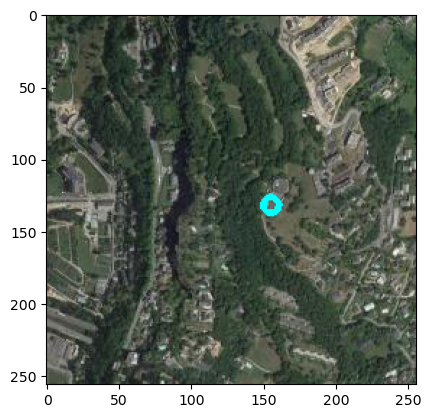

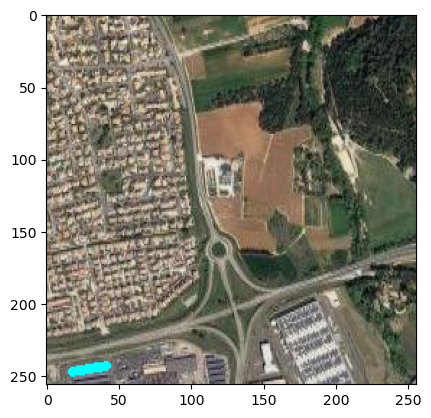

In [59]:
for row_index, row_data in gdf.head(5).iterrows():
    img = utils.download_img_from_tiles(row_data.tiles_x, row_data.tiles_y, zoom, source='google')
    
    outlined_img = cv2.polylines(img, [row_data.poly_px_coords], True, (0,255,255), thickness=3)
    plt.imshow(outlined_img)
    plt.show()

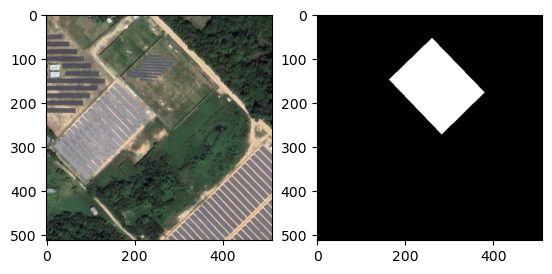

Save image for training ([Yes]/No):  ''


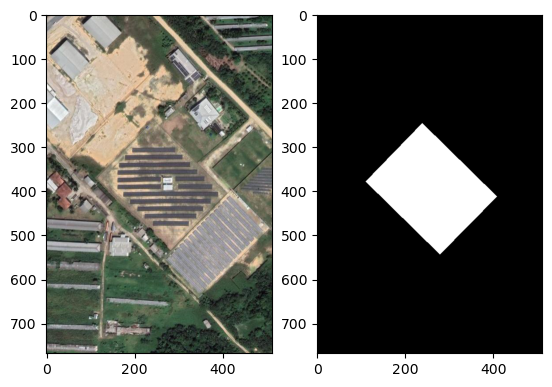


KeyboardInterrupt



In [48]:
mask_256_20pct_filled = 3355443
mask_256_80pct_filled = 13421771

for row_index, row_data in gdf.iloc[1100:].iterrows():
    source = 'arcgis' if np.random.rand() > 0.5 else 'google'
    img = utils.download_img_from_tiles(row_data.tiles_x, row_data.tiles_y, zoom, source=source)
    mask = cv2.fillPoly(np.zeros(img.shape[:2]), [row_data.poly_px_coords], color=255)
    
    # display the images
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img)
    axarr[1].imshow(mask, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    ignore = input('Save image for training ([Yes]/No): ')
    if ignore:
        continue
    
    clear_output()
    img_cut = 0
    for img_part, mask_part in zip(utils.img_spliter(img), utils.img_spliter(mask, color=False)):        
        if mask_part.sum() < mask_256_20pct_filled or mask_part.sum() > mask_256_80pct_filled or mask_part[80:176, 80:176].sum() < 1:
            continue
        img_cut += 1   
        
        # f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(img_part)
        # axarr[1].imshow(mask_part, cmap='gray', vmin=0, vmax=255)
        # plt.show()
        # # clear_output()
    
        # training and validation set
        if np.random.rand() > 0.2:
            cv2.imwrite(f'D:\documents\master_dataset_1\\train_images\img\img_{zoom}_{row_index}_{img_cut}.png', img_part)
            cv2.imwrite(f'D:\documents\master_dataset_1\\train_masks\img\img_{zoom}_{row_index}_{img_cut}.png', mask_part)
        else:
            cv2.imwrite(f'D:\documents\master_dataset_1\\val_images\img\img_{zoom}_{row_index}_{img_cut}.png', img_part)
            cv2.imwrite(f'D:\documents\master_dataset_1\\val_masks\img\img_{zoom}_{row_index}_{img_cut}.png', mask_part)